# Microearthquake Catalog Data Analysis and Total Events Calculation

### By Geophysics Team PT Supreme Energy

Notebook ini berisikan analisis data secara deskriptif dan visualisasi dari data microearthquake (MEQ) yang telah diperoleh melalui proses pengolahan, dari raw data hasil akuisisi lapangan hingga melalui proses waveform cross correlation (WCC). Analisis data diperlukan untuk menemukan pola dan wawasan dari fitur-fitur yang tersedia. Adapun pada notebook ini berisikan perhitungan total event gempa mikro secara temporal yang diekstrak dari catalog untuk kebutuhan interpretasi gabungan dengan data subsurface lainnya. 

Analisis data menggunakan pendekatan data science dilakukan pada katalog hipocenter dimulai dari December 2020 (Event ID 2001) digabungkan dengan data katalog hipocenter dari Januari 2023 (Event ID 2719) hingga Oktober 2023 (Event ID 3288). Event ID 2719 - 3288 diperoleh dari excel sheet bernama "MEQ_NLL_HYPODD_CATALOG_19_01_2023" pada sheet "DD+WCC Scheme 1 " yang mana proses hypoDD dengan WCC menggunakan pendekatan "Max event separation 600m/max median error".   

## Data Understanding

| Attribute | Description |
| --- | --- |
| ID | ID data dari gempa mikro yang terekam|
| Lat | Koordinat garis lintang dari gempa mikro |
| Lon | Koordinat garis bujur dari gempa mikro |
| UTM X (m) | Koordinat timur (easting) dari kejadian gempa mikro dalam sistem UTM |
| UTM Y (m) | Koordinat utara (northing) dari kejadian gempa mikro dalam sistem UTM |
| Elev (down is +m) | Kedalaman gempa mikro dalam meter, kedalaman akan bernilai negatif jika diatas permukaan laut |
| Elev (m) | Ketinggian gempa mikro dalam meter, elevasi akan bernilai negatif jka dibawah permukaan |
| Year | Tahun dimana gempa mikro dalam satu ID terekam |
| Month | Bulan dimana gempa mikro dalam satu ID terekam |
| Day | Hari dimana gempa mikro dalam satu ID terekam |
| Hour | Jam dimana gempa mikro dalam satu ID terekam |
| Minute | Menit dimana gempa mikro dalam satu ID terekam |
| OT(sec) | Detik dimana gempa mikro dalam satu ID terekam |
| Remarks | Keterangan jenis gempa mikro; inisial atau relokasi |
| Ml Magnitude | Nilai lokal magnitudo |
| Mw Magnitude | Nilai momen magnitudo |

#### Libraries Set Up 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import seaborn as sns
import missingno
import plotly.graph_objects as go

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from scipy.stats import normaltest
from sklearn.impute import SimpleImputer

### Data Loading

In [2]:
# Membaca data dari file Excel
df = pd.read_excel('Hypocenter Catalog December 2020 - October 2023.xlsx') 
df

ID       Lat         Lon       UTM X        UTM Y  Elev (down is +m)  \
0    2001 -1.598386  101.162896  740640.625  9823203.125           -890.625   
1    2005 -1.639367  101.149183  739109.375  9818671.875            953.125   
2    2014 -1.577068  101.150942  739312.500  9825562.500           6687.500   
3    2016 -1.650112  101.140772  738171.875  9817484.375           1171.875   
4    2019 -1.638524  101.144971  738640.625  9818765.625            796.875   
..    ...       ...         ...         ...          ...                ...   
893  3284 -1.642259  101.142448  738359.378  9818352.809            776.460   
894  3285 -1.642577  101.139429  738023.280  9818317.951            719.500   
895  3286 -1.645168  101.135295  737562.818  9818031.846            786.150   
896  3287 -1.631970  101.121634  736043.899  9819493.304            212.358   
897  3288 -1.643077  101.150773  739285.943  9818261.268           1018.760   

     Elev (masl)  Year  Month  Day  Hour  Minute  Origin (s)  RMS error DD  \
0        890.625  2020     12   13    14      57   47.844215      0.023990   
1       -953.125  2020     12   23    17      20   54.558533      0.022201   
2      -6687.500  2020     12   30    15       3   30.640550      0.071077   
3      -1171.875  2021      1    2    12      52    3.690430      0.028875   
4       -796.875  2021      1    5    16       8   57.712376      0.025909   
..           ...   ...    ...  ...   ...     ...         ...           ...   
893     -776.460  2023     10   14    16      31   41.020001      0.002658   
894     -719.500  2023     10   17     8      13   56.790001      0.002386   
895     -786.150  2023     10   17     9       1   32.360001      0.002576   
896     -212.358  2023     10   18     0      33   19.668341      0.009786   
897    -1018.760  2023     10   18    14      21   34.669998      0.000048   

     MI Magnitude  Mw Magnitude  Remarks  
0             NaN           NaN  Initial  
1             NaN           NaN    Reloc  
2             NaN           NaN  Initial  
3             NaN           NaN    Reloc  
4             NaN           NaN    Reloc  
..            ...           ...      ...  
893           NaN           NaN      WCC  
894           NaN           NaN      WCC  
895           NaN           NaN      WCC  
896           NaN           NaN  Initial  
897           NaN           NaN    Reloc  

[898 rows x 17 columns]

In [3]:
df.columns

Index(['ID', 'Lat', 'Lon', 'UTM X', 'UTM Y', 'Elev (down is +m)',
       'Elev (masl)', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Origin (s)',
       'RMS error DD', 'MI Magnitude', 'Mw Magnitude', 'Remarks'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 898 non-null    int64  
 1   Lat                898 non-null    float64
 2   Lon                898 non-null    float64
 3   UTM X              898 non-null    float64
 4   UTM Y              898 non-null    float64
 5   Elev (down is +m)  898 non-null    float64
 6   Elev (masl)        898 non-null    float64
 7   Year               898 non-null    int64  
 8   Month              898 non-null    int64  
 9   Day                898 non-null    int64  
 10  Hour               898 non-null    int64  
 11  Minute             898 non-null    int64  
 12  Origin (s)         898 non-null    float64
 13  RMS error DD       898 non-null    float64
 14  MI Magnitude       666 non-null    float64
 15  Mw Magnitude       666 non-null    float64
 16  Remarks            898 non

* Dapat Dilihat bahwa katalog MEQ dari 13-12-2020 hingga 18-10-2023 memiliki 15 kolom dan 898 baris
* Adapun terdapat 15 kolom bertipe numerikal dan 1 kolom bertipe kategorikal.
* Katalog MEQ akan terus di-update secara temporal jika terjadi penambahan jumlah gempa mikro yang teridentifikasi, menyebabkan baris pada dataset akan terus bertambah.

### Identifikasi dan Penanganan Nilai yang Hilang (Identification and Handling Missing Value)

<Axes: >

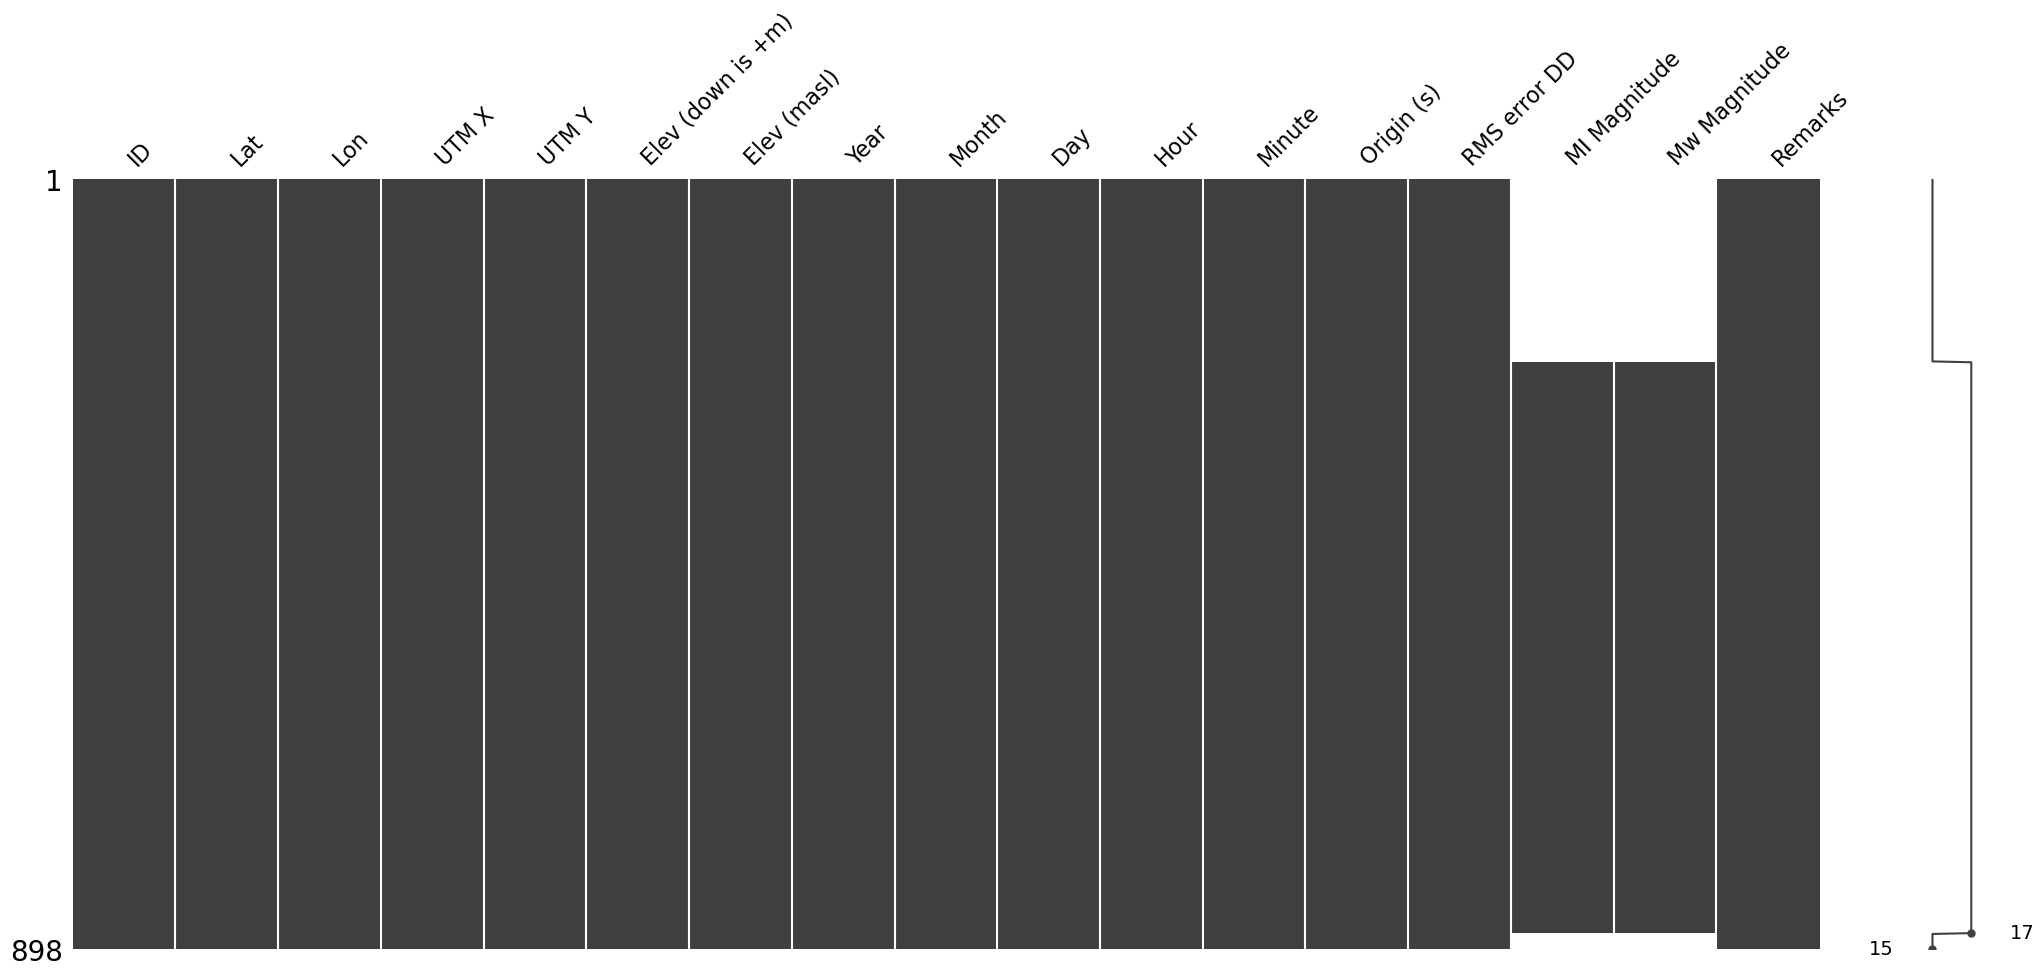

In [5]:
missingno.matrix(df)

In [6]:
df.isna().sum()/df.shape[0]*100

ID                    0.000000
Lat                   0.000000
Lon                   0.000000
UTM X                 0.000000
UTM Y                 0.000000
Elev (down is +m)     0.000000
Elev (masl)           0.000000
Year                  0.000000
Month                 0.000000
Day                   0.000000
Hour                  0.000000
Minute                0.000000
Origin (s)            0.000000
RMS error DD          0.000000
MI Magnitude         25.835189
Mw Magnitude         25.835189
Remarks               0.000000
dtype: float64

Terdapat missing value pada fitur numerikal `MI Magnitude` and `Mw Magnitude`, sehingga perlu dilakukan penanganan untuk mengisi missing value tersebut. Jika distribusi data pada fitur numerikal bersifat normal distribution, maka missing value akan diisi dengan mean dan jika distribusi bersifat right- atau left-skewed maka missing value akan diisi dengan median. Dibawah ini menampilkan plot distribusi untuk mengecek karakteristik distribusi data pada fitur `MI Magnitude` and `Mw Magnitude`.

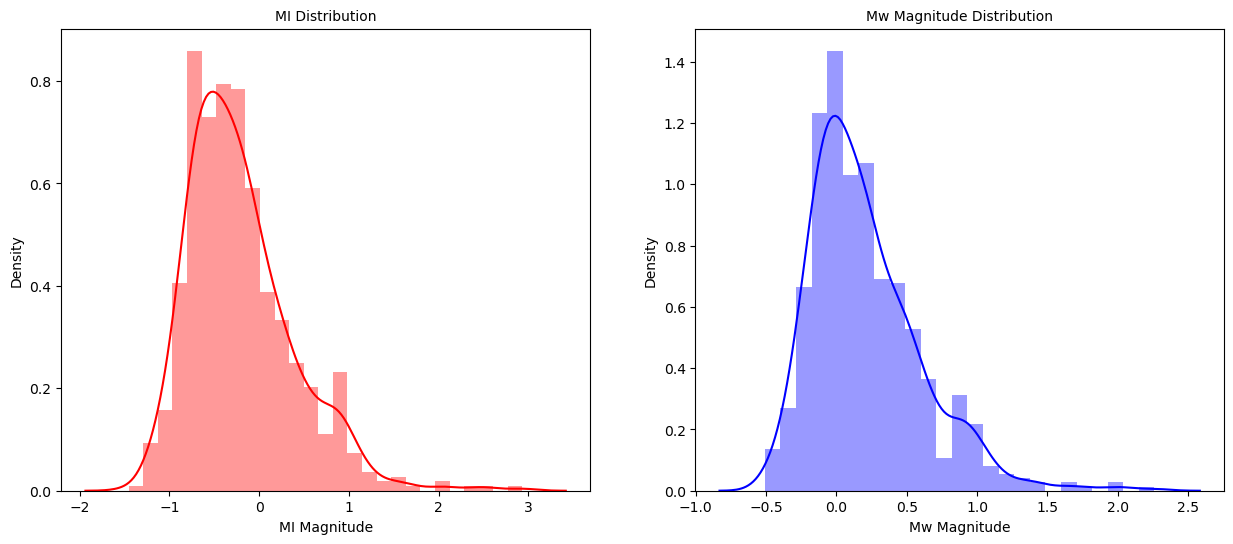

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))

sns.distplot(df['MI Magnitude'], color='red', ax=axs[0])
axs[0].set_title('MI Distribution', size=10)

sns.distplot(df['Mw Magnitude'], color='blue', ax=axs[1])
axs[1].set_title('Mw Magnitude Distribution', size=10)

plt.show()

* Dari plot distribusi untuk fitur lokal dan momen magnitude dapat dilihat memiliki distribusi yang bersifat right-skewed atau dengan kata lain distribusi datanya tidak normal, sehingga pengisian value yang hilang akan dilakukan dengan mengisi nilai mediannya.

In [8]:
# Select float columns
float_columns = df.select_dtypes(include=[float]).columns

# Simple imputation using median for all float features
simple_impute = SimpleImputer(strategy='median')
df[float_columns] = simple_impute.fit_transform(df[float_columns])

<Axes: >

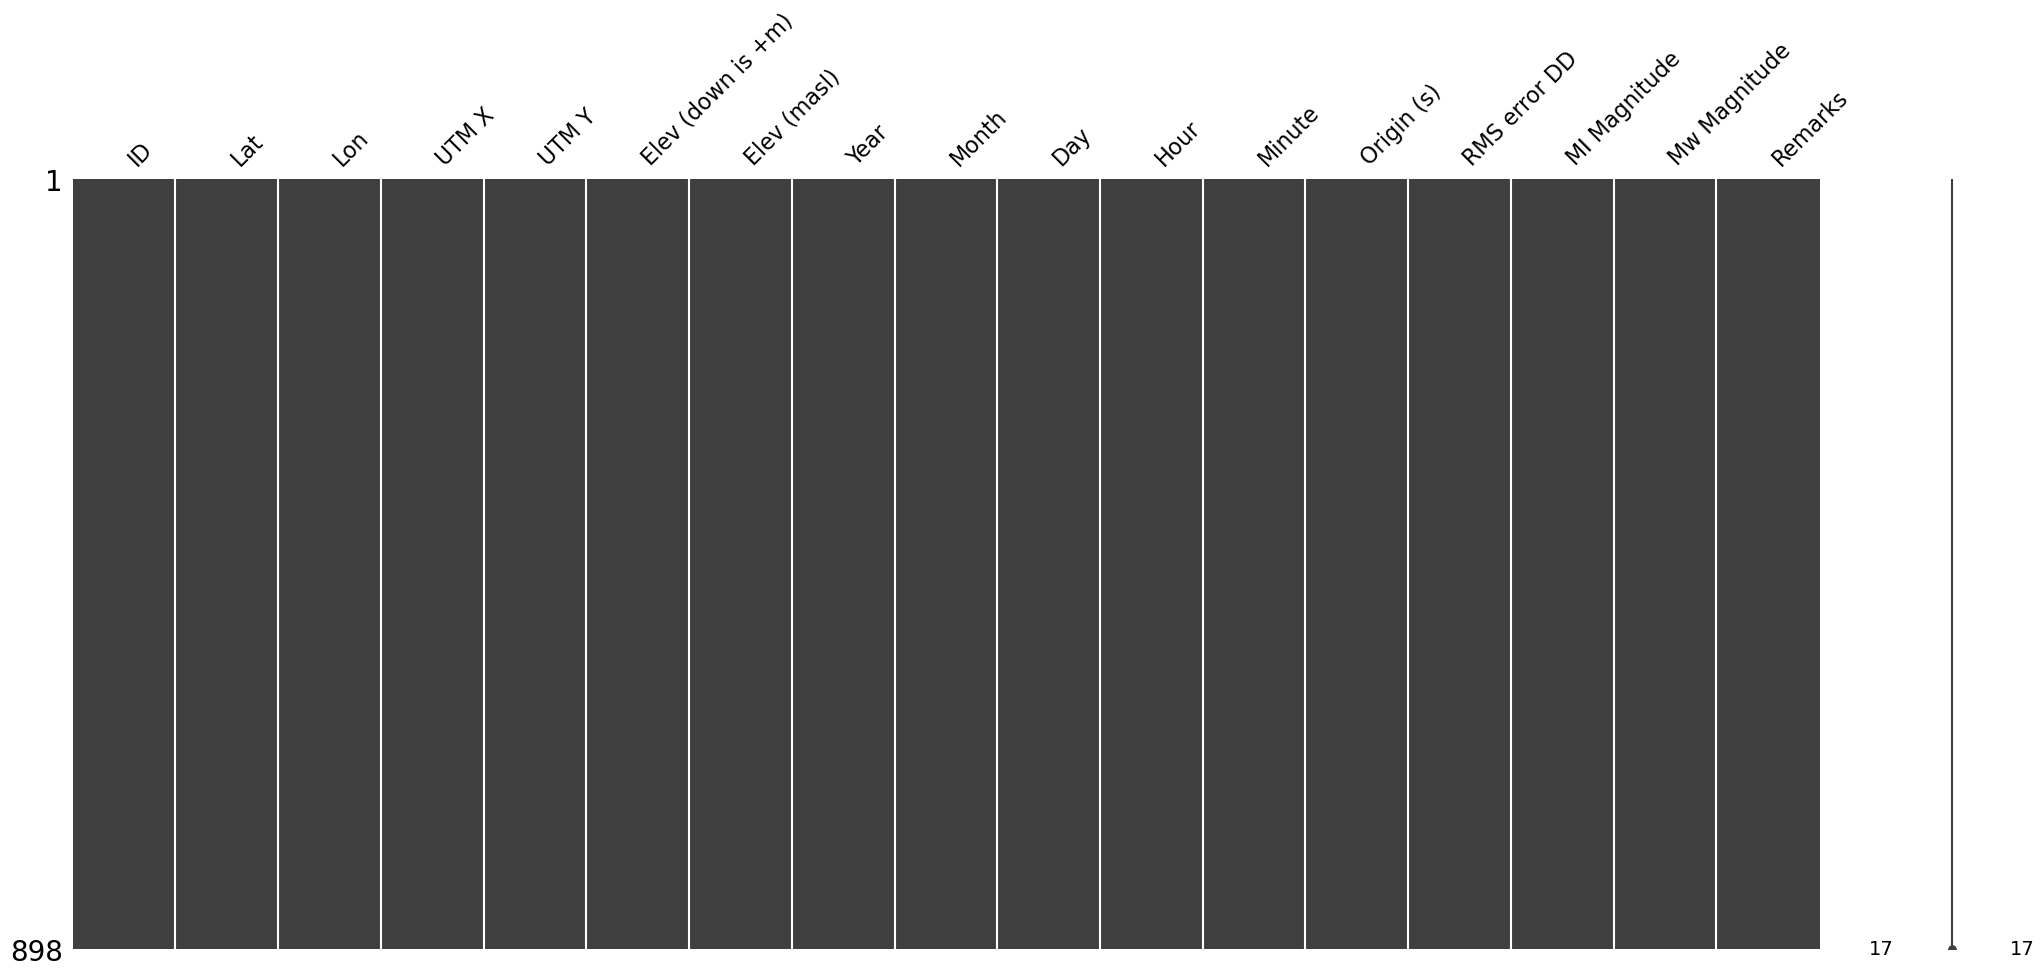

In [9]:
missingno.matrix(df)

Dataset kini sudah tidak memiliki missing value dan siap untuk dianalisis

### Statistik Deskriptif

In [10]:
df['MI Magnitude'].describe()

count    898.000000
mean      -0.234321
std        0.510585
min       -1.454000
25%       -0.526750
50%       -0.310500
75%       -0.077500
max        2.934000
Name: MI Magnitude, dtype: float64

In [11]:
df['Mw Magnitude'].describe()

count    898.000000
mean       0.187390
std        0.341627
min       -0.509000
25%       -0.012500
50%        0.131500
75%        0.280000
max        2.262000
Name: Mw Magnitude, dtype: float64

* Berdasarkan nilai maksimum dari lokal dan momen magnitude, semua gelombang seismik yang terekam merupakan gempa-gempa mikro karena memiliki magnitudo lebih kecil dari 3. 
* Lokal magnitude paling besar yakni sebesar 2.934 dan momen magnitude paling besar yakni bernilai 2.262
* Gempa mikro muncul bisa diakibatkan oleh kegiatan produksi lapangan geotermal, injeksi fluida, kegiatan pengeboran, dan lainnya. 

In [12]:
df['Remarks'].value_counts()

WCC        491
Reloc      248
Initial    159
Name: Remarks, dtype: int64

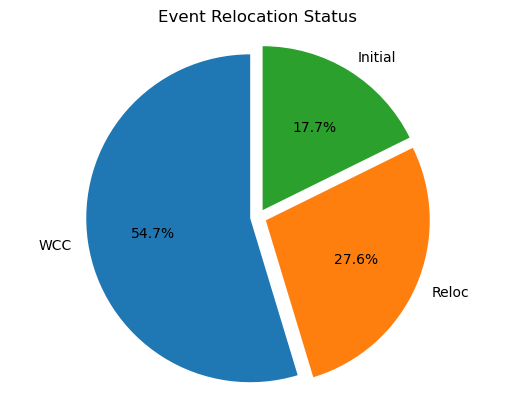

In [13]:
# Count the values in the 'y' column
value_counts = df['Remarks'].value_counts()

# Create a pie chart
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, explode = [0.05,0.05, 0.05])
plt.title('Event Relocation Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

* Untuk satu-satunya fitur yang bersifat kategorikal, dapat terlihat 54.7% event gempa mikro yang telah direlokasi hingga melalui proses waveform cross correlation (WCC).

### Feature Engineering

Karena data memiliki fitur tahun, bulan, dan hari yang terpisah sehingga bisa diperoleh satu fitur baru yang merepresentasikan tanggal yang akan berguna untuk kebutuhan analisis data secara temporal.

In [14]:
# Buat kolom 'date'
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Tampilkan DataFrame
df

ID       Lat         Lon       UTM X        UTM Y  Elev (down is +m)  \
0    2001 -1.598386  101.162896  740640.625  9823203.125           -890.625   
1    2005 -1.639367  101.149183  739109.375  9818671.875            953.125   
2    2014 -1.577068  101.150942  739312.500  9825562.500           6687.500   
3    2016 -1.650112  101.140772  738171.875  9817484.375           1171.875   
4    2019 -1.638524  101.144971  738640.625  9818765.625            796.875   
..    ...       ...         ...         ...          ...                ...   
893  3284 -1.642259  101.142448  738359.378  9818352.809            776.460   
894  3285 -1.642577  101.139429  738023.280  9818317.951            719.500   
895  3286 -1.645168  101.135295  737562.818  9818031.846            786.150   
896  3287 -1.631970  101.121634  736043.899  9819493.304            212.358   
897  3288 -1.643077  101.150773  739285.943  9818261.268           1018.760   

     Elev (masl)  Year  Month  Day  Hour  Minute  Origin (s)  RMS error DD  \
0        890.625  2020     12   13    14      57   47.844215      0.023990   
1       -953.125  2020     12   23    17      20   54.558533      0.022201   
2      -6687.500  2020     12   30    15       3   30.640550      0.071077   
3      -1171.875  2021      1    2    12      52    3.690430      0.028875   
4       -796.875  2021      1    5    16       8   57.712376      0.025909   
..           ...   ...    ...  ...   ...     ...         ...           ...   
893     -776.460  2023     10   14    16      31   41.020001      0.002658   
894     -719.500  2023     10   17     8      13   56.790001      0.002386   
895     -786.150  2023     10   17     9       1   32.360001      0.002576   
896     -212.358  2023     10   18     0      33   19.668341      0.009786   
897    -1018.760  2023     10   18    14      21   34.669998      0.000048   

     MI Magnitude  Mw Magnitude  Remarks       date  
0         -0.3105        0.1315  Initial 2020-12-13  
1         -0.3105        0.1315    Reloc 2020-12-23  
2         -0.3105        0.1315  Initial 2020-12-30  
3         -0.3105        0.1315    Reloc 2021-01-02  
4         -0.3105        0.1315    Reloc 2021-01-05  
..            ...           ...      ...        ...  
893       -0.3105        0.1315      WCC 2023-10-14  
894       -0.3105        0.1315      WCC 2023-10-17  
895       -0.3105        0.1315      WCC 2023-10-17  
896       -0.3105        0.1315  Initial 2023-10-18  
897       -0.3105        0.1315    Reloc 2023-10-18  

[898 rows x 18 columns]

In [15]:
df['date'].value_counts()

2023-01-20    89
2023-09-14    77
2023-09-28    57
2023-06-06    51
2023-07-19    50
              ..
2022-03-13     1
2022-03-21     1
2022-03-30     1
2022-03-31     1
2022-05-26     1
Name: date, Length: 229, dtype: int64

Informasi dari pengulangan data pada fitur tanggal secara tidak langsung menunjukan ada berapa kali event gempa mikro yang terjadi ditanggal tertentu. Maka dari itu informasi ini bisa berguna untuk menghitung berapa total event gempa mikro hariannya dan akan dibahas secara detail di bagian 'Total Events Calculation Overtime'

# Microearthquake Exploratory Data Analysis 

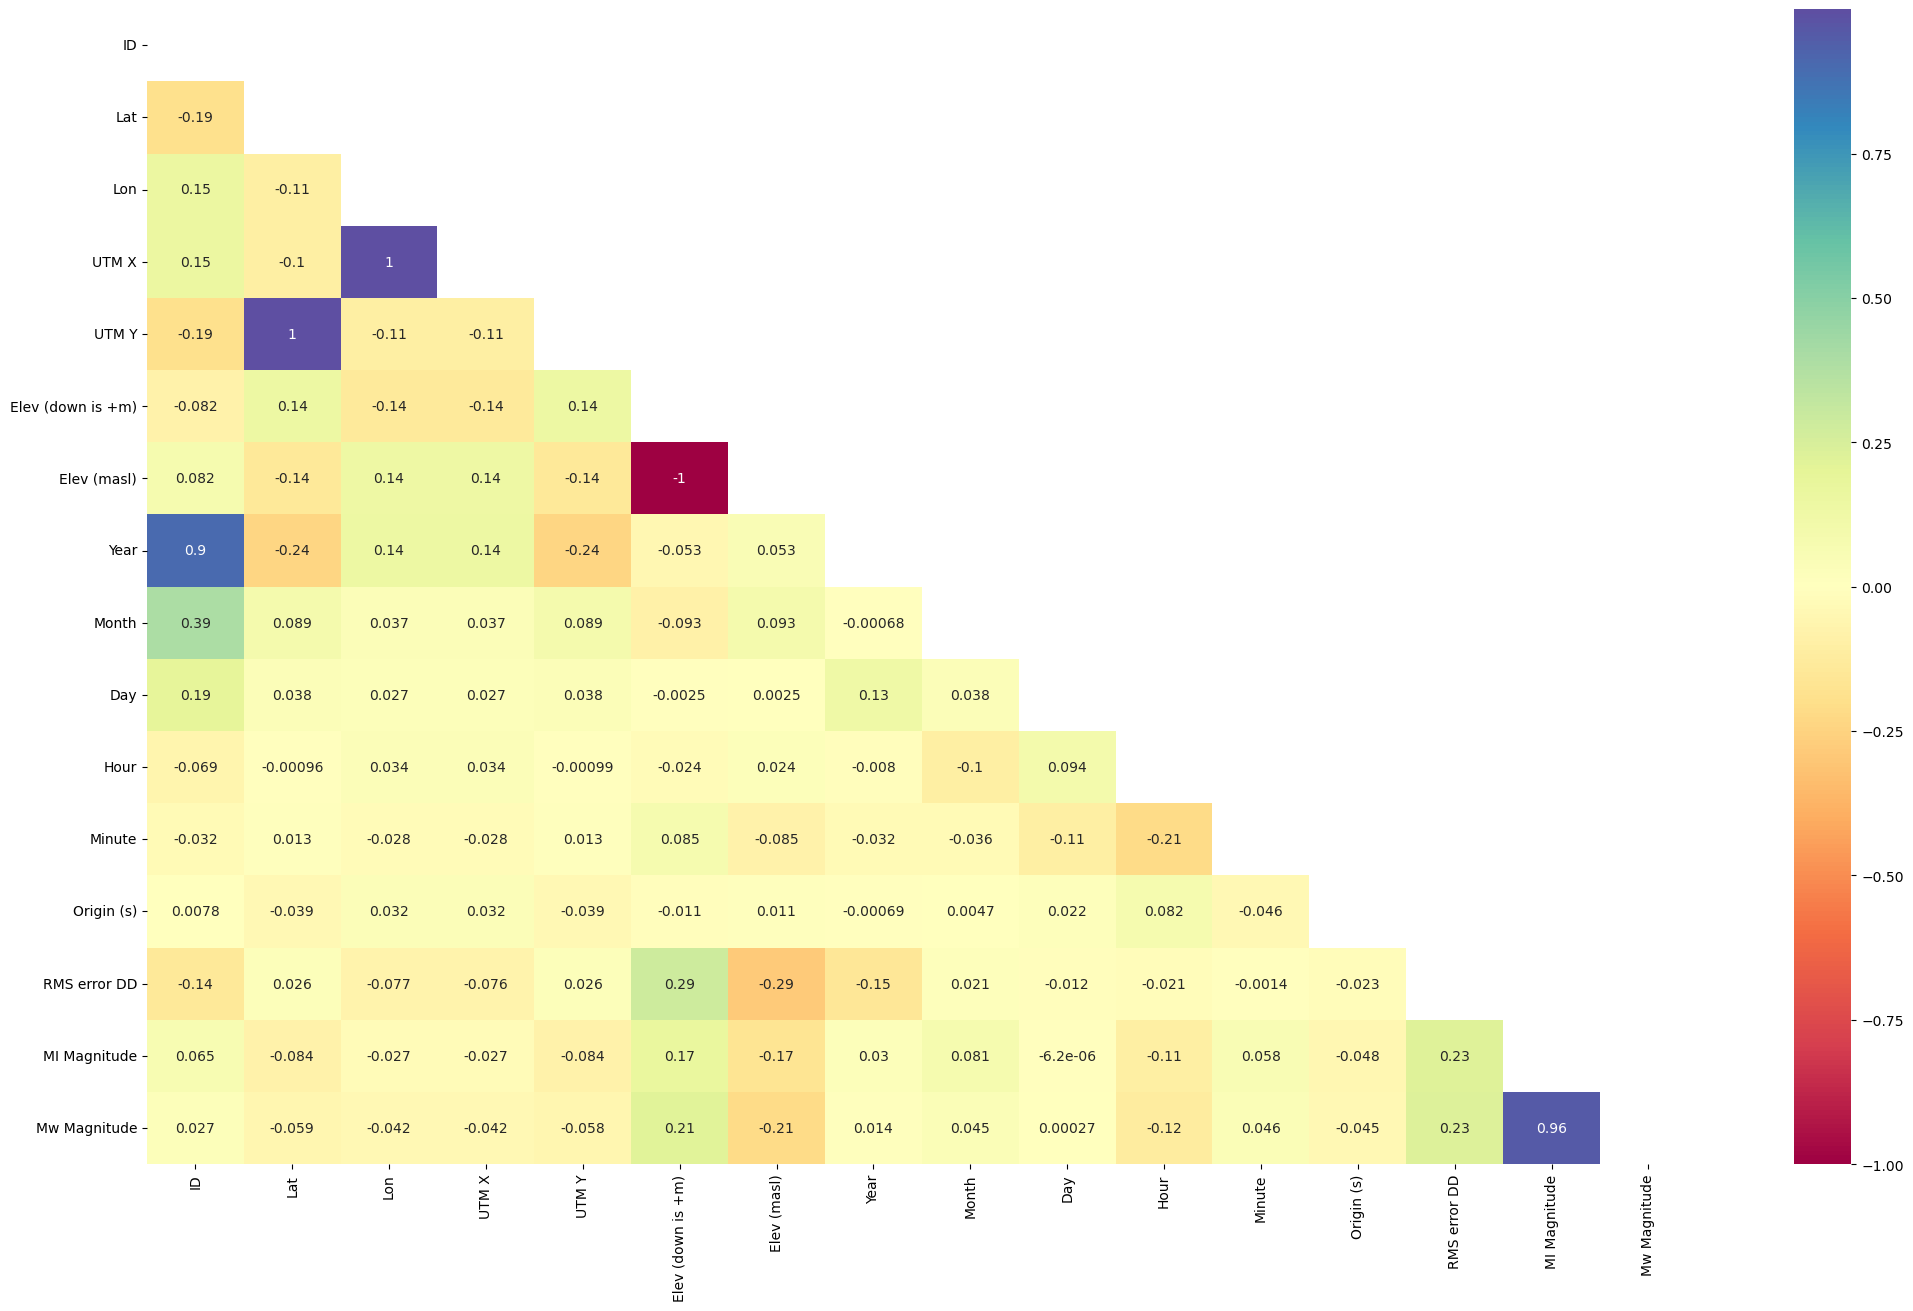

In [16]:
corrmat = df.corr(method='pearson')

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

plt.figure(figsize=(25,15))
sns.heatmap(corrmat, annot=True, cmap='Spectral', center=0, mask=mask)
plt.show()

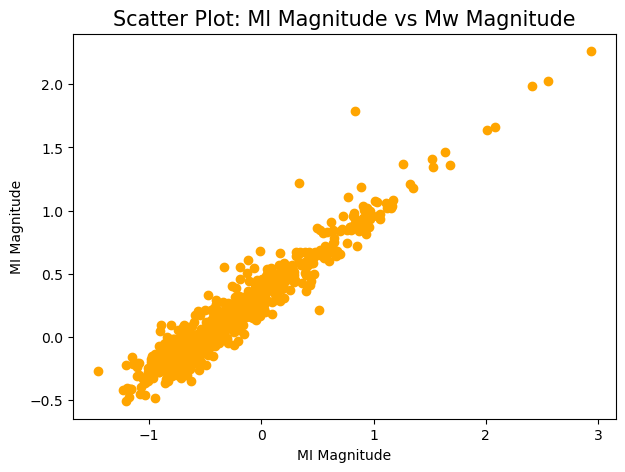

In [17]:
plt.figure(figsize=(7,5))
plt.scatter(df['MI Magnitude'], df['Mw Magnitude'], color = 'orange')
plt.title('Scatter Plot: Ml Magnitude vs Mw Magnitude', size = 15)
plt.xlabel('MI Magnitude')
plt.ylabel('MI Magnitude')
plt.show()

In [18]:
df[['MI Magnitude', 'Mw Magnitude']].corr()

MI Magnitude  Mw Magnitude
MI Magnitude      1.000000      0.959512
Mw Magnitude      0.959512      1.000000

* Berdasarkan korelasi pearson, terlihat adanya korelasi positif dari parameter magnitudo lokal dan momen, seiring meningkatnya lokal magnitude akan berpengaruh pada peningkatan momen magnitude.

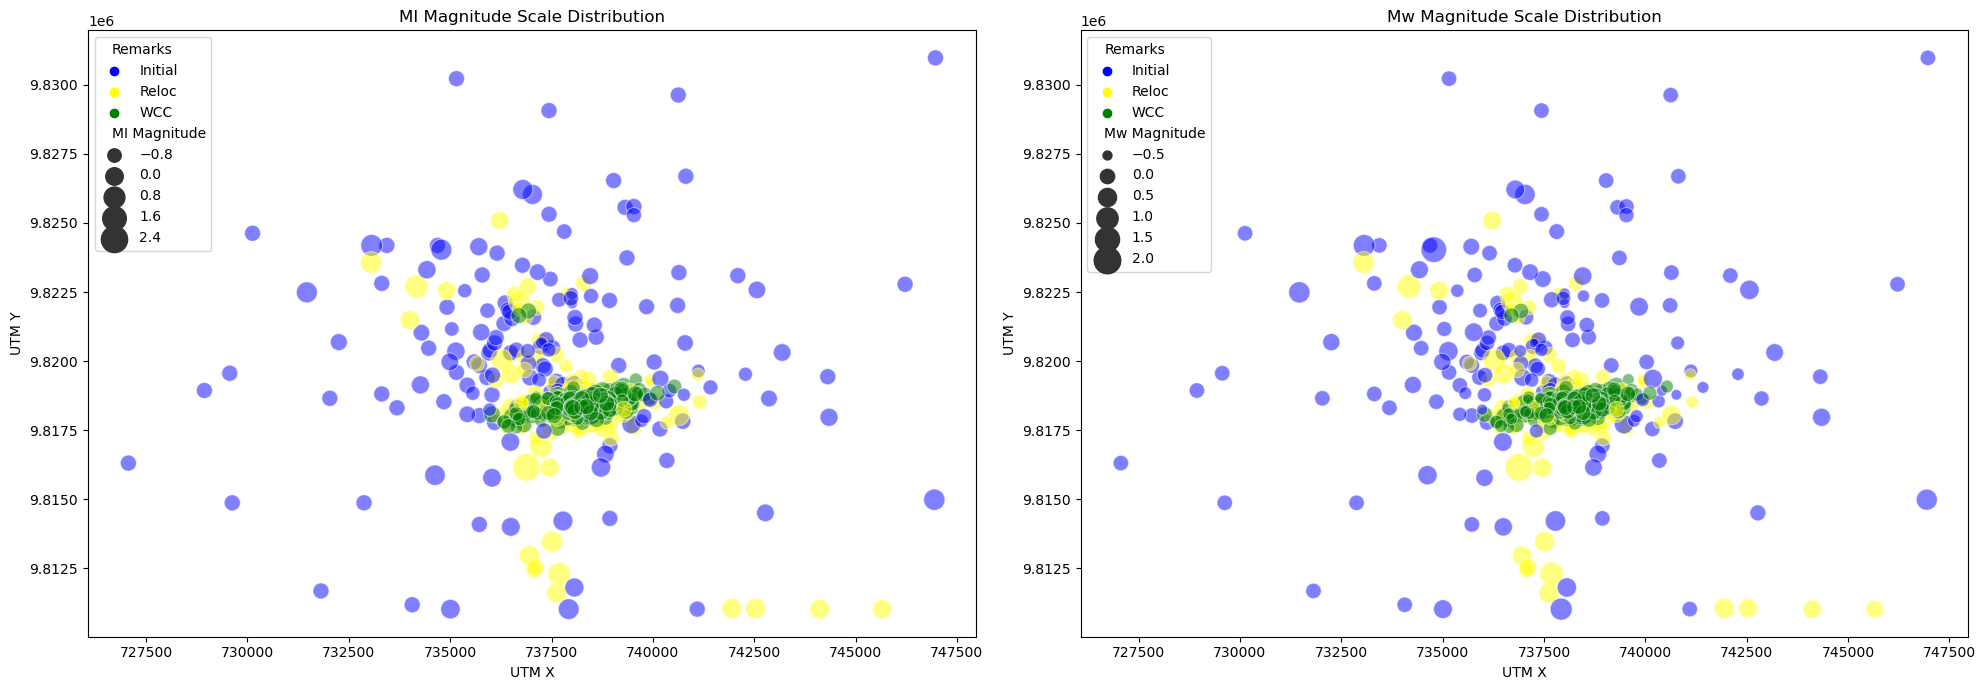

In [19]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot pertama - Relation plot untuk MI Magnitude
sns.scatterplot(x='UTM X', y='UTM Y', hue='Remarks', size='MI Magnitude',
                sizes=(40, 400), alpha=.5,palette={"Initial": "blue", "Reloc": "yellow", "WCC": "green"},
                data=df, ax=axes[0])

axes[0].set_xlabel('UTM X')
axes[0].set_ylabel('UTM Y')
axes[0].set_title('MI Magnitude Scale Distribution')

# Plot kedua - Relation plot untuk Mw Magnitude
sns.scatterplot(x='UTM X', y='UTM Y', hue='Remarks', size='Mw Magnitude',
                sizes=(40, 400), alpha=.5, palette={"Initial": "blue", "Reloc": "yellow", "WCC": "green"},
                data=df, ax=axes[1])

axes[1].set_xlabel('UTM X')
axes[1].set_ylabel('UTM Y')
axes[1].set_title('Mw Magnitude Scale Distribution')

# Adjust layout
plt.tight_layout()
plt.show()

* Dari kedua plot lokal dan momen magnitude, terlihat hasil relokasi menggunakan WCC lebih terpusat pada zona diantara 735000 - 740000 UTM X dan 9.8175 - 9.8200 UTM Y, berorientasi ENE-WSW serta memiliki value magnitude lokal dan momen lebih kecil dari 2. 
* Sebagai tambahan informasi mempertimbangkan keberadaan sumur injeksi secara geospasial, event seismic cenderung teridentifikasi di sumur ML-B yang berdekatan dengan major fault F#1 dan F#20, sehingga kemunculan event-event microseismic bisa jadi akibat fault reactivation.

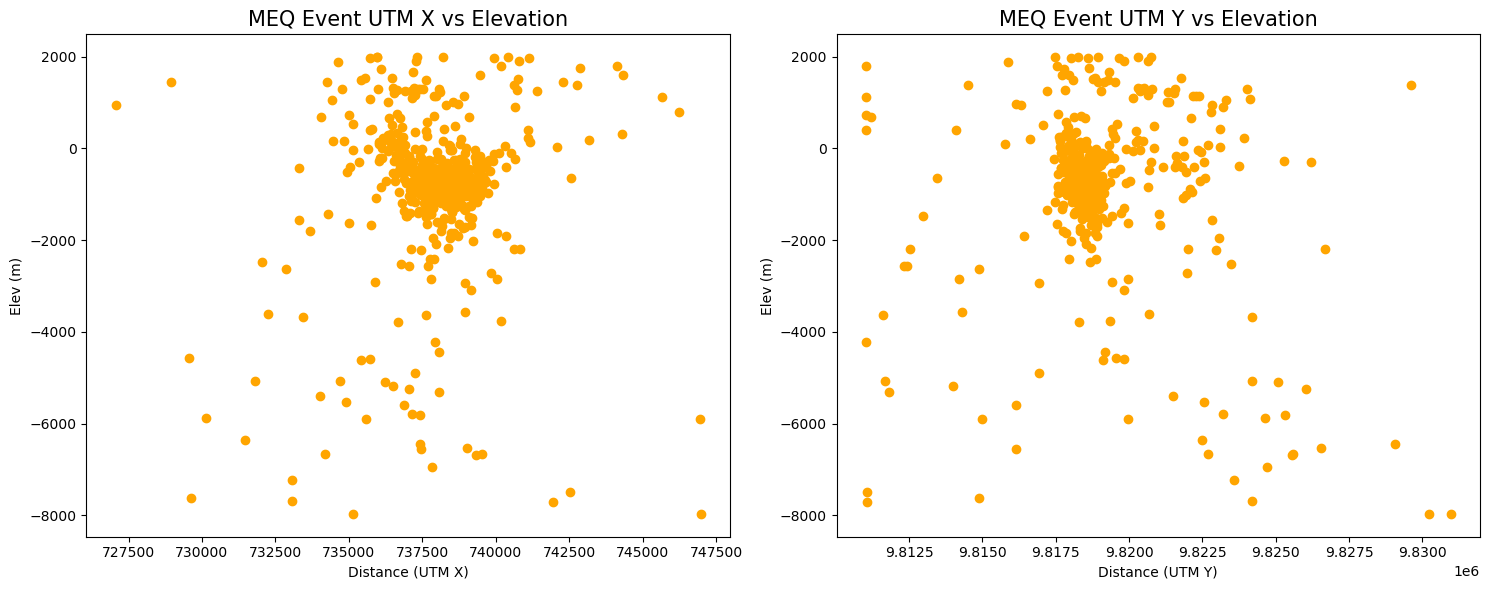

In [20]:
# Membuat subplot dengan ukuran 2x1
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot pertama
axs[0].scatter(df['UTM X'], df['Elev (masl)'], color='orange')
axs[0].set_title('MEQ Event UTM X vs Elevation', size=15)
axs[0].set_xlabel('Distance (UTM X)')
axs[0].set_ylabel('Elev (m)')

# Plot kedua
axs[1].scatter(df['UTM Y'], df['Elev (masl)'], color='orange')
axs[1].set_title('MEQ Event UTM Y vs Elevation', size=15)
axs[1].set_xlabel('Distance (UTM Y)')
axs[1].set_ylabel('Elev (m)')

# Menyesuaikan layout
plt.tight_layout()
plt.show()

* Dari kedua plot sistem koordinat UTM X dan Y versus kedalaman, terlihat mayoritas event gempa mikro berada pada kedalaman dangkal 0 - 2000 m.

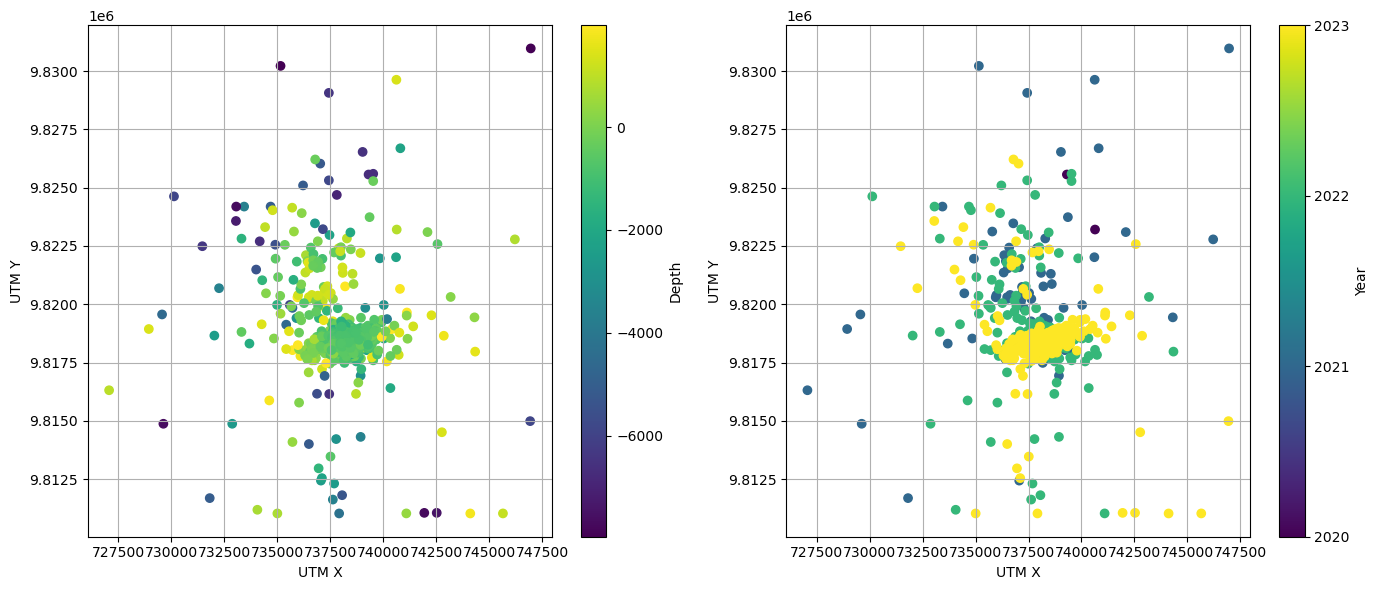

In [21]:
# Plot pertama
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
depth_start = min(df['Elev (masl)'])
depth_end = max(df['Elev (masl)'])
plt.scatter(df['UTM X'], df['UTM Y'], c=df['Elev (masl)'], cmap='viridis')
plt.colorbar(label='Depth')
plt.xlabel('UTM X')
plt.ylabel('UTM Y')
#plt.title('Scatter Plot of UTM X and UTM Y with Depth Color Bar')
plt.grid(True)

# Plot kedua
plt.subplot(1, 2, 2)
year_start = min(df['Year'])
year_end = max(df['Year'])
plt.scatter(df['UTM X'], df['UTM Y'], c=df['Year'], cmap='viridis')
plt.colorbar(ticks=range(year_start, year_end + 1), label='Year')
plt.xlabel('UTM X')
plt.ylabel('UTM Y')
#plt.title('Scatter Plot of UTM X and UTM Y with Year Color Bar')
plt.grid(True)

# Menyesuaikan layout
plt.tight_layout()

* Mayoritas gempa mikro terjadi pada kedalaman dangkal.
* Gempa mikro dominan terjadi pada tahun 2023.
* Jika dilihat secara spasial dan temporal, gempa mikro yang terdapat pada kedalaman dangkal didominasi oleh gempa mikro yang terjadi di tahun 2023, meskipun di daerah selatan dan barat laut terdapat gempa mikro yang terjadi di tahun 2023 namun berada dikedalaman lebih besar dari 4000 m dibawah permukaan.

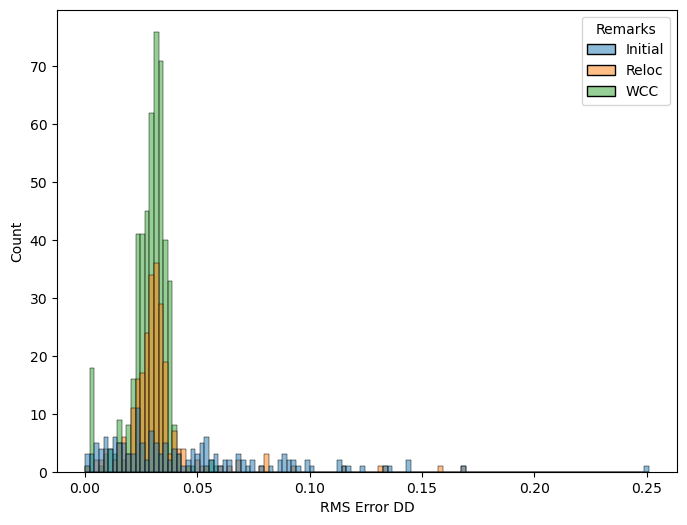

In [22]:
plt.figure(figsize=(8,6))
sns.histplot(x='RMS error DD', hue='Remarks', data=df,)
plt.xlabel('RMS Error DD')
plt.ylabel('Count')
plt.show()

* Secara umum dapat terlihat penerapan double difference untuk relocation memiliki distribusi RMS error yang bersifat right-skewed distribution.
* Adapun data yang telah direlokasi dan melalui proses WCC dominan berada direntang 0.025 - 0.050 

# Total Events Calculation Over Time

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 898 non-null    int64         
 1   Lat                898 non-null    float64       
 2   Lon                898 non-null    float64       
 3   UTM X              898 non-null    float64       
 4   UTM Y              898 non-null    float64       
 5   Elev (down is +m)  898 non-null    float64       
 6   Elev (masl)        898 non-null    float64       
 7   Year               898 non-null    int64         
 8   Month              898 non-null    int64         
 9   Day                898 non-null    int64         
 10  Hour               898 non-null    int64         
 11  Minute             898 non-null    int64         
 12  Origin (s)         898 non-null    float64       
 13  RMS error DD       898 non-null    float64       
 14  MI Magnitu

Pengulangan tanggal pada dataset akan dijadikan perhitungan untuk menghitung total kejadian gempa mikro yang terjadi ditanggal tersebut, kemudian perhitungan total kejadian gempa mikro ini dan kapan terjadinya akan disimpan kedalam file berformat excel (.xlsx) yang bisa digunakan untuk kebutuhan interpretasi data dengan menggabungkannya dengan data subsurface lainnya seperti laju injeksi.

In [24]:
# Contoh hasil value_counts()
value_counts_result = df['date'].value_counts().reset_index()

# Ubah nama kolom
value_counts_result.columns = ['date', 'total_meq_events']

# Buat rentang tanggal lengkap
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
full_date_df = pd.DataFrame({'date': full_date_range})

# Gabungkan dengan hasil value_counts() dan isi nilai yang hilang dengan 0
result_df = pd.merge(full_date_df, value_counts_result, on='date', how='left').fillna(0)

# Urutkan berdasarkan tanggal
result_df = result_df.sort_values(by='date')

# Simpan ke file Excel
#result_df.to_excel('Total_MEQ_Events.xlsx', index=False)

In [25]:
df2 = pd.read_excel('Total_MEQ_Events.xlsx') 
df2

date  total_meq_events
0    2020-12-13                 1
1    2020-12-14                 0
2    2020-12-15                 0
3    2020-12-16                 0
4    2020-12-17                 0
...         ...               ...
1035 2023-10-14                 3
1036 2023-10-15                 0
1037 2023-10-16                 0
1038 2023-10-17                 2
1039 2023-10-18                 2

[1040 rows x 2 columns]

### Interactive Plot

In [26]:
fig = go.Figure([go.Scatter(x = df2['date'], y = df2['total_meq_events'])])


fig.update_layout(
    yaxis_title='Total MEQ Events',
    xaxis=dict(rangeslider_visible=True)
)
fig.show()

Berdasarkan data, total kejadian gempa mikro mengalami peningkatan di tahun 2023. Pada awal tahun 2023 terjadi perekahan yang terjadi secara signifikan yang kemungkinan besar diakibatkan oleh injection rate. Kemudian total kejadian gempa mikro kembali mengalami peningkatan pada akhir kuartal 2 dan terus mengalami peningkatan jumlah gempa mikro di kuartal 3 tahun 2023.  

In [27]:
df2['cum_sum_meq_event'] = df2['total_meq_events'].cumsum()
df2

date  total_meq_events  cum_sum_meq_event
0    2020-12-13                 1                  1
1    2020-12-14                 0                  1
2    2020-12-15                 0                  1
3    2020-12-16                 0                  1
4    2020-12-17                 0                  1
...         ...               ...                ...
1035 2023-10-14                 3                894
1036 2023-10-15                 0                894
1037 2023-10-16                 0                894
1038 2023-10-17                 2                896
1039 2023-10-18                 2                898

[1040 rows x 3 columns]

In [28]:
# Ekstrak informasi tahun
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day

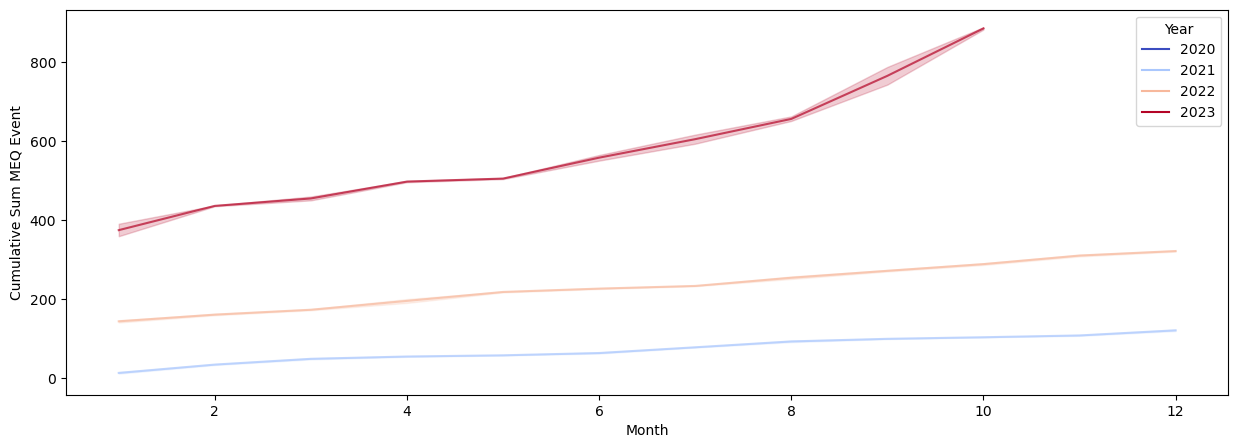

In [29]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='month', y='cum_sum_meq_event', hue='year', data=df2, palette='coolwarm', alpha=0.7)
#sns.lineplot(x='month', y='total_meq_events', hue='year', data=df2)
plt.xlabel('Month')
plt.ylabel('Cumulative Sum MEQ Event')
plt.legend(title='Year', loc='upper right')
plt.show()

* Jumlah kumulatif gempa mikro ditahun 2023 lebih banyak dihasilkan dari tahun-tahun sebelumnya
* Terjadi peningkatan jumlah gempa mikro sebesar 100% dari Januari 2023 - hingga Oktober 2023.

### Kesimpulan

* Keluaran dari proses data analisis adalah ditemukannya beberapa insight dari katalog MEQ yakni:
    1. Keseluruhan data magnitudo lokal dan momen, memiliki nilai maksimal dibawah 3, hal ini mengindikasikan semua kejadian gempa yang ada pada dataset katalog MEQ merupakan jenis gempa mikro.
    2. Hasil relokasi melalui proses WCC menunjukkan lebih terpusat pada zona diantara 735000 - 740000 UTM X dan 9.8175 - 9.8200 UTM Y, berorientasi ENE-WSW serta memiliki value magnitude lokal dan momen lebih kecil dari 2.
    3. Dari analisis spasial dan temporal, gempa mikro yang terdapat pada kedalaman dangkal didominasi oleh gempa mikro yang terjadi di tahun 2023, meskipun di daerah selatan dan barat laut terdapat gempa mikro yang terjadi di tahun 2023 namun berada dikedalaman lebih besar dari 4000 m dibawah permukaan.
    4. Gempa mikro yang telah direlokasi dan melalui proses WCC memiliki RMS error pada rentang 0.025 - 0.050.
    5. Terjadi peningkatan jumlah kejadian gempa dari tahun ketahun, dan secara signifikan kejadian gempa mikro meningkat di tahun 2023.

*Tambahan:

1. Gempa mikro dipengaruhi oleh injection rate, fitur geologi seperti patahan, litologi, dan lokasi dari feedzone, dan saturasi formasi.
     
2. Event seismic cenderung teridentifikasi di sumur ML-B yang berdekatan dengan major fault F#1 dan F#20, sehingga kemunculan event-event microseismic bisa jadi akibat fault reactivation.

    